In [2]:
import numpy as np
import pandas as pd

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12213399021803532586
xla_global_id: -1
]


2022-08-11 14:06:26.314906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-11 14:06:26.362713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 14:06:26.385424: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-08-11 14:06:26.387246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file

In [5]:
DATA = 'transcriptase'
MODEL_SUFFIX = '6_atmesta_random'

In [6]:
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [7]:
with np.load(f'data/{DATA}/train_cut.npz', allow_pickle = True) as data:
    X = data['parents']
    Y = data['children']
    V = data['vocab_index'].tolist()

In [8]:
print(X.shape)
print(Y.shape)
print(V)

(17210, 236, 23)
(17210, 236, 23)
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'X': 20, 'Y': 21, 'Z': 22}


In [9]:
W = dict((i, char) for char, i in V.items())
decode_seq = lambda seq: [ ''.join([ W[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [10]:
legit_values = [decoded_x.startswith('PISP') and decoded_y.startswith('PISP')   for decoded_x, decoded_y  in zip(decode_seq(X), decode_seq(Y))]
X = X[legit_values]
Y = Y[legit_values]

In [11]:
i = 5
print(decode_seq(X[i:i+1])[0])
print(decode_seq(Y[i:i+1])[0])

PISPIETVPVKLKPGMDGPKVKQWPLTEXKIKALVEICTEMEKEGKISKIGPENPYNTPVFAIKKKBSTXWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKXKSVTVLDVGDAYFSVPLDEDFRKYTAFTIPSLNNETPGIRYQYNVLPQGWKGSPAIFQSSMTKILEPFRKQNPDIVIYQYMDDLYVGSDLEIEQHRTKIEELRQHLLRWGLTTPDXKHQKEPPFLWMGYELHP
PISPIETVPVKLKPGMDGPKVKQWPLTEDKIKALVEICTEMEKEGKISKIGPENPYNTPVFAIKKXDSTKWRKLVDFRELNKRTQDFWEVQLGIPHPAGLKKXKSVTVLDVGDAYFSVPLDEDFRKYTAFTIPSLNNETPGIRYQYNVLPQGWKGSPAIFQSSMTKILEPFRKQXPDIVIYQYMDDLYVGSDLEIEQHRXKIEELRQHLLKWGLTTPDKKHQKEPPFLWMGYELHP


## Modelis

In [14]:
len(decode_seq(X[i:i+1])[0])

236

In [15]:
n_hidden = 16

# (1, 236)(2, 118)(4, 59)
n_length = 4
n_splits = X.shape[1] // n_length

n_hidden, n_length, n_splits

(16, 4, 59)

In [16]:
input_train = Input(shape=(X.shape[1], X.shape[2]), name="parent_input")
input_rand_rate = Input(shape=(), name="random_input")
output_train = Input(shape=(Y.shape[1], Y.shape[2]), name="child_output")

print(input_train)
print(input_rand_rate)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 236, 23), dtype=tf.float32, name='parent_input'), name='parent_input', description="created by layer 'parent_input'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name='random_input'), name='random_input', description="created by layer 'random_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 236, 23), dtype=tf.float32, name='child_output'), name='child_output', description="created by layer 'child_output'")


In [17]:
splits = tf.split(input_train, num_or_size_splits=n_splits, axis=1)
concat = tf.concat(splits, axis=0)
print(concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 23), dtype=tf.float32, name=None), name='tf.concat/concat:0', description="created by layer 'tf.concat'")


2022-08-11 14:07:06.772164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 14:07:06.772563: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
    return_sequences = True, return_state = True)(concat)
print(encoder_stack_h)
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 16), dtype=tf.float32, name=None), name='gru/transpose_1:0', description="created by layer 'gru'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gru/while:4', description="created by layer 'gru'")


In [19]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
decoder_input = RepeatVector(concat.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 16), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [20]:
decoder_stack_h = GRU(n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = encoder_last_h)
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 16), dtype=tf.float32, name=None), name='gru_1/transpose_1:0', description="created by layer 'gru_1'")


In [21]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [22]:
class RandomDropout(keras.layers.Layer):
    
    def call(self, inputs, rate):
        return tf.nn.dropout(inputs, rate=rate[0])
    

In [23]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
context = RandomDropout()(context, input_rand_rate)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 16), dtype=tf.float32, name=None), name='random_dropout/dropout/Mul:0', description="created by layer 'random_dropout'")


In [24]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 32), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [25]:
out = TimeDistributed(Dense(concat.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 23), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [26]:
back_splits = tf.split(out, num_or_size_splits=n_splits, axis=0)
back_concat = tf.concat(back_splits, axis=1)
print(back_concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 236, 23), dtype=tf.float32, name=None), name='tf.concat_1/concat:0', description="created by layer 'tf.concat_1'")


In [27]:
model = Model(inputs = [input_train, input_rand_rate], outputs = back_concat)
opt = keras.optimizers.Adam(learning_rate = 0.05, clipnorm = 1, amsgrad = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 parent_input (InputLayer)      [(None, 236, 23)]    0           []                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 4, 23),      0           ['parent_input[0][0]']           
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                               

                                                                  'tf.split[0][18]',              
                                                                  'tf.split[0][19]',              
                                                                  'tf.split[0][20]',              
                                                                  'tf.split[0][21]',              
                                                                  'tf.split[0][22]',              
                                                                  'tf.split[0][23]',              
                                                                  'tf.split[0][24]',              
                                                                  'tf.split[0][25]',              
                                                                  'tf.split[0][26]',              
                                                                  'tf.split[0][27]',              
          

                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
                                 (None, 4, 23),                                                   
          

                                                                  'tf.split_1[0][31]',            
                                                                  'tf.split_1[0][32]',            
                                                                  'tf.split_1[0][33]',            
                                                                  'tf.split_1[0][34]',            
                                                                  'tf.split_1[0][35]',            
                                                                  'tf.split_1[0][36]',            
                                                                  'tf.split_1[0][37]',            
                                                                  'tf.split_1[0][38]',            
                                                                  'tf.split_1[0][39]',            
                                                                  'tf.split_1[0][40]',            
          

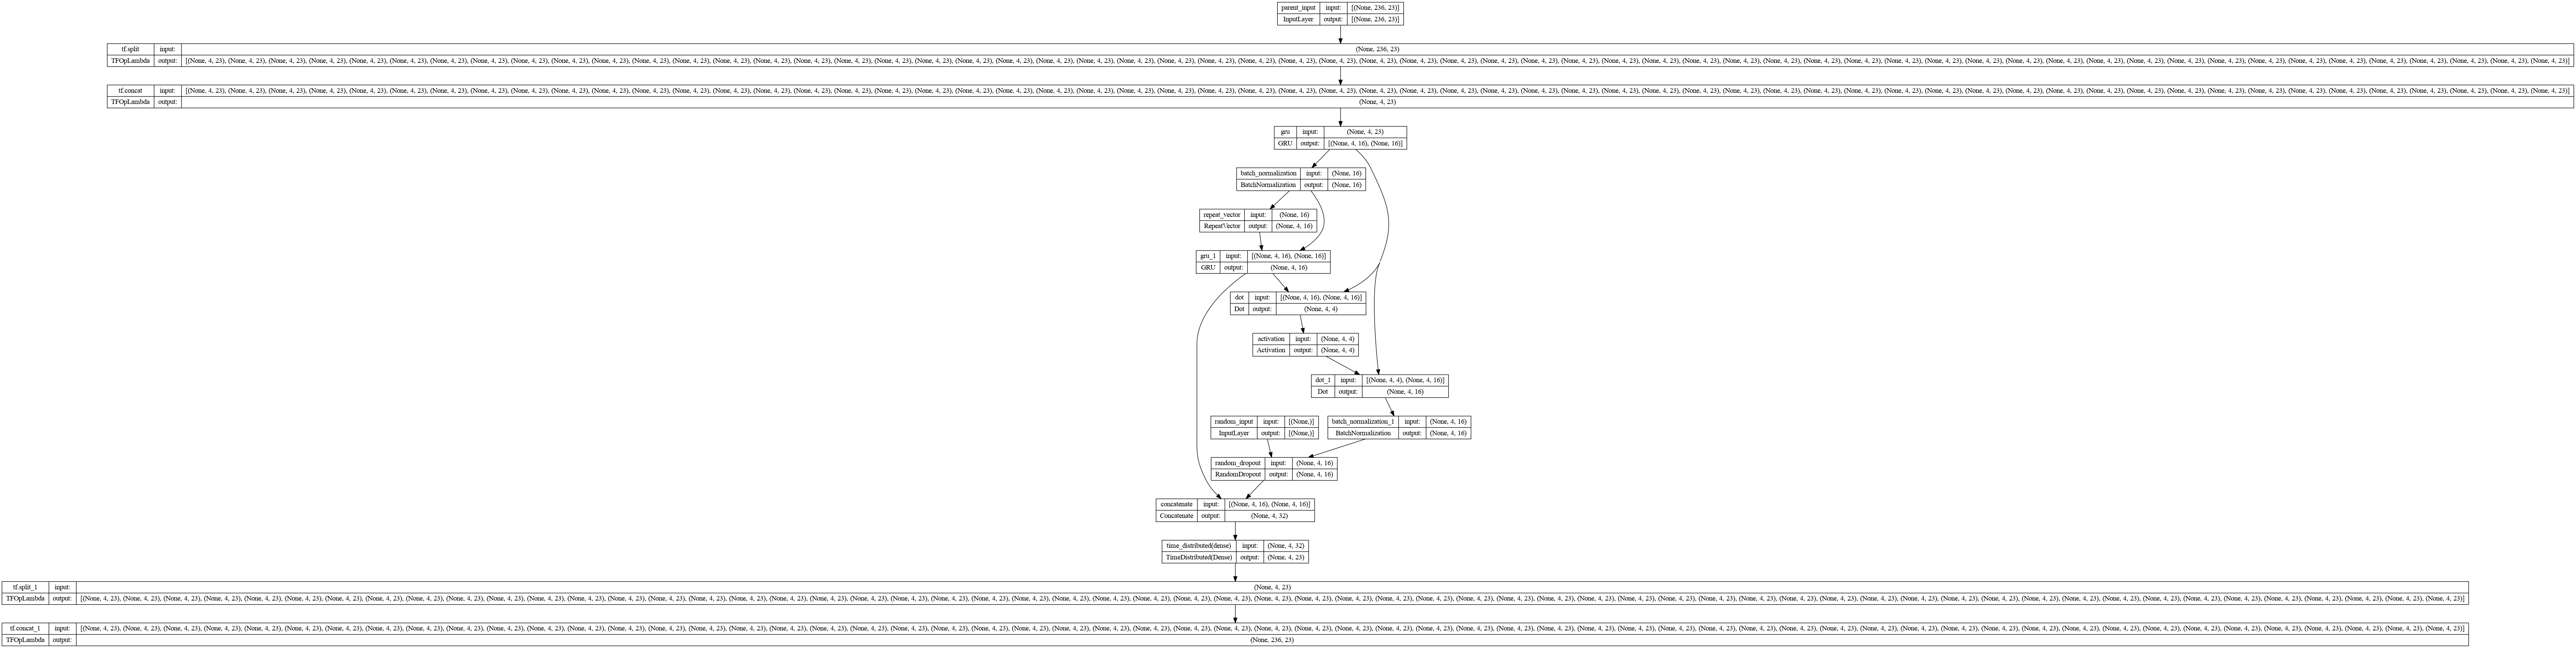

In [28]:
keras.utils.plot_model(model, to_file = f'model_{DATA}_{MODEL_SUFFIX}_plot.png', show_shapes = True, show_layer_names = True)

## Train

In [29]:
batch_size = 64      # Batch size for training.
patience = 150        # Patience for EarlyStop
epochs = 2500        # Number of epochs to train for.
rand_rate = np.full((len(X)), 0.538708241062535)
rand_rate.shape

(13495,)

In [30]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit([ X, rand_rate ], Y, 
                    validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)

# train_mae = history.history['accuracy']
# valid_mae = history.history['val_accuracy']

Epoch 1/2500
169/169 [==============================] - 8s 28ms/step - loss: 0.5472 - accuracy: 0.8591 - val_loss: 0.1767 - val_accuracy: 0.9701
Epoch 2/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.2517 - accuracy: 0.9528 - val_loss: 0.1599 - val_accuracy: 0.9722
Epoch 3/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.2312 - accuracy: 0.9566 - val_loss: 0.1512 - val_accuracy: 0.9727
Epoch 4/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.2215 - accuracy: 0.9585 - val_loss: 0.1483 - val_accuracy: 0.9733
Epoch 5/2500
169/169 [==============================] - 6s 33ms/step - loss: 0.2161 - accuracy: 0.9593 - val_loss: 0.1464 - val_accuracy: 0.9729
Epoch 6/2500
169/169 [==============================] - 5s 30ms/step - loss: 0.2133 - accuracy: 0.9599 - val_loss: 0.1483 - val_accuracy: 0.9729
Epoch 7/2500
169/169 [==============================] - 5s 27ms/step - loss: 0.2100 - accuracy: 0.9604 - val_loss: 0.1437 - val_ac

169/169 [==============================] - 4s 25ms/step - loss: 0.1962 - accuracy: 0.9631 - val_loss: 0.1383 - val_accuracy: 0.9738
Epoch 58/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1965 - accuracy: 0.9629 - val_loss: 0.1370 - val_accuracy: 0.9738
Epoch 59/2500
169/169 [==============================] - 5s 28ms/step - loss: 0.1967 - accuracy: 0.9629 - val_loss: 0.1389 - val_accuracy: 0.9743
Epoch 60/2500
169/169 [==============================] - 5s 32ms/step - loss: 0.1957 - accuracy: 0.9631 - val_loss: 0.1364 - val_accuracy: 0.9739
Epoch 61/2500
169/169 [==============================] - 5s 27ms/step - loss: 0.1958 - accuracy: 0.9630 - val_loss: 0.1368 - val_accuracy: 0.9738
Epoch 62/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1960 - accuracy: 0.9630 - val_loss: 0.1377 - val_accuracy: 0.9740
Epoch 63/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1959 - accuracy: 0.9631 - val_loss: 0.1392 - val_accuracy:

169/169 [==============================] - 5s 29ms/step - loss: 0.1941 - accuracy: 0.9634 - val_loss: 0.1360 - val_accuracy: 0.9746
Epoch 114/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1938 - accuracy: 0.9634 - val_loss: 0.1372 - val_accuracy: 0.9740
Epoch 115/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1939 - accuracy: 0.9634 - val_loss: 0.1368 - val_accuracy: 0.9743
Epoch 116/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1939 - accuracy: 0.9634 - val_loss: 0.1355 - val_accuracy: 0.9746
Epoch 117/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1939 - accuracy: 0.9635 - val_loss: 0.1355 - val_accuracy: 0.9746
Epoch 118/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1938 - accuracy: 0.9634 - val_loss: 0.1368 - val_accuracy: 0.9740
Epoch 119/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1938 - accuracy: 0.9635 - val_loss: 0.1360 - val_acc

Epoch 169/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1930 - accuracy: 0.9637 - val_loss: 0.1400 - val_accuracy: 0.9739
Epoch 170/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1933 - accuracy: 0.9636 - val_loss: 0.1361 - val_accuracy: 0.9741
Epoch 171/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1933 - accuracy: 0.9636 - val_loss: 0.1350 - val_accuracy: 0.9742
Epoch 172/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1929 - accuracy: 0.9636 - val_loss: 0.1357 - val_accuracy: 0.9747
Epoch 173/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1929 - accuracy: 0.9637 - val_loss: 0.1340 - val_accuracy: 0.9746
Epoch 174/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1926 - accuracy: 0.9636 - val_loss: 0.1348 - val_accuracy: 0.9743
Epoch 175/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1923 - accuracy: 0.9638 - val_loss: 0

Epoch 225/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1922 - accuracy: 0.9637 - val_loss: 0.1350 - val_accuracy: 0.9744
Epoch 226/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1926 - accuracy: 0.9636 - val_loss: 0.1354 - val_accuracy: 0.9744
Epoch 227/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1915 - accuracy: 0.9638 - val_loss: 0.1351 - val_accuracy: 0.9736
Epoch 228/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1919 - accuracy: 0.9638 - val_loss: 0.1351 - val_accuracy: 0.9745
Epoch 229/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1915 - accuracy: 0.9639 - val_loss: 0.1356 - val_accuracy: 0.9742
Epoch 230/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1922 - accuracy: 0.9637 - val_loss: 0.1367 - val_accuracy: 0.9742
Epoch 231/2500
169/169 [==============================] - 4s 24ms/step - loss: 0.1917 - accuracy: 0.9637 - val_loss: 0

Epoch 281/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1916 - accuracy: 0.9638 - val_loss: 0.1350 - val_accuracy: 0.9744
Epoch 282/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1911 - accuracy: 0.9639 - val_loss: 0.1335 - val_accuracy: 0.9747
Epoch 283/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1912 - accuracy: 0.9638 - val_loss: 0.1351 - val_accuracy: 0.9747
Epoch 284/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1916 - accuracy: 0.9637 - val_loss: 0.1369 - val_accuracy: 0.9743
Epoch 285/2500
169/169 [==============================] - 4s 24ms/step - loss: 0.1916 - accuracy: 0.9637 - val_loss: 0.1363 - val_accuracy: 0.9745
Epoch 286/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1915 - accuracy: 0.9636 - val_loss: 0.1362 - val_accuracy: 0.9739
Epoch 287/2500
169/169 [==============================] - 4s 27ms/step - loss: 0.1914 - accuracy: 0.9639 - val_loss: 0

Epoch 337/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1911 - accuracy: 0.9638 - val_loss: 0.1345 - val_accuracy: 0.9737
Epoch 338/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1905 - accuracy: 0.9641 - val_loss: 0.1346 - val_accuracy: 0.9744
Epoch 339/2500
169/169 [==============================] - 5s 27ms/step - loss: 0.1911 - accuracy: 0.9638 - val_loss: 0.1339 - val_accuracy: 0.9746
Epoch 340/2500
169/169 [==============================] - 5s 27ms/step - loss: 0.1906 - accuracy: 0.9639 - val_loss: 0.1334 - val_accuracy: 0.9746
Epoch 341/2500
169/169 [==============================] - 5s 27ms/step - loss: 0.1907 - accuracy: 0.9640 - val_loss: 0.1349 - val_accuracy: 0.9745
Epoch 342/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1906 - accuracy: 0.9639 - val_loss: 0.1349 - val_accuracy: 0.9749
Epoch 343/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1910 - accuracy: 0.9639 - val_loss: 0

Epoch 393/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1908 - accuracy: 0.9638 - val_loss: 0.1344 - val_accuracy: 0.9745
Epoch 394/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1907 - accuracy: 0.9640 - val_loss: 0.1355 - val_accuracy: 0.9747
Epoch 395/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1911 - accuracy: 0.9639 - val_loss: 0.1345 - val_accuracy: 0.9747
Epoch 396/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1909 - accuracy: 0.9639 - val_loss: 0.1350 - val_accuracy: 0.9745
Epoch 397/2500
169/169 [==============================] - 5s 28ms/step - loss: 0.1905 - accuracy: 0.9639 - val_loss: 0.1359 - val_accuracy: 0.9744
Epoch 398/2500
169/169 [==============================] - 5s 28ms/step - loss: 0.1905 - accuracy: 0.9639 - val_loss: 0.1353 - val_accuracy: 0.9741
Epoch 399/2500
169/169 [==============================] - 5s 28ms/step - loss: 0.1904 - accuracy: 0.9641 - val_loss: 0

Epoch 449/2500
169/169 [==============================] - 5s 30ms/step - loss: 0.1905 - accuracy: 0.9640 - val_loss: 0.1336 - val_accuracy: 0.9749
Epoch 450/2500
169/169 [==============================] - 5s 27ms/step - loss: 0.1907 - accuracy: 0.9640 - val_loss: 0.1341 - val_accuracy: 0.9739
Epoch 451/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1907 - accuracy: 0.9639 - val_loss: 0.1351 - val_accuracy: 0.9743
Epoch 452/2500
169/169 [==============================] - 5s 27ms/step - loss: 0.1904 - accuracy: 0.9639 - val_loss: 0.1356 - val_accuracy: 0.9747
Epoch 453/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1906 - accuracy: 0.9640 - val_loss: 0.1350 - val_accuracy: 0.9741
Epoch 454/2500
169/169 [==============================] - 5s 27ms/step - loss: 0.1905 - accuracy: 0.9640 - val_loss: 0.1350 - val_accuracy: 0.9745
Epoch 455/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1903 - accuracy: 0.9640 - val_loss: 0

Epoch 505/2500
169/169 [==============================] - 5s 31ms/step - loss: 0.1900 - accuracy: 0.9640 - val_loss: 0.1345 - val_accuracy: 0.9747
Epoch 506/2500
169/169 [==============================] - 5s 27ms/step - loss: 0.1896 - accuracy: 0.9642 - val_loss: 0.1335 - val_accuracy: 0.9749
Epoch 507/2500
169/169 [==============================] - 4s 26ms/step - loss: 0.1903 - accuracy: 0.9640 - val_loss: 0.1347 - val_accuracy: 0.9737
Epoch 508/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1897 - accuracy: 0.9641 - val_loss: 0.1361 - val_accuracy: 0.9739
Epoch 509/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1897 - accuracy: 0.9641 - val_loss: 0.1351 - val_accuracy: 0.9743
Epoch 510/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1900 - accuracy: 0.9640 - val_loss: 0.1356 - val_accuracy: 0.9744
Epoch 511/2500
169/169 [==============================] - 4s 25ms/step - loss: 0.1904 - accuracy: 0.9640 - val_loss: 0

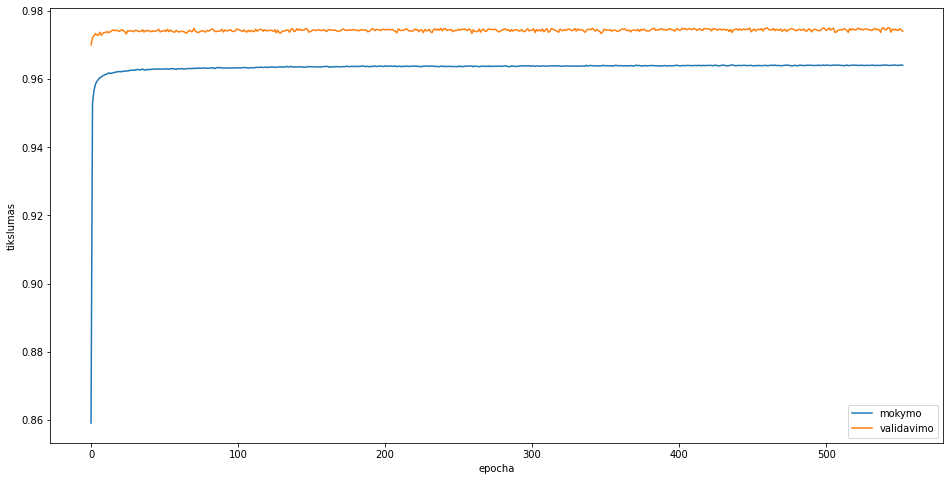

In [31]:
plt.plot(history.history['accuracy'], label = 'mokymo')
plt.plot(history.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.savefig(f'./plots/{DATA}_{MODEL_SUFFIX}_accuracy.png')
plt.show()

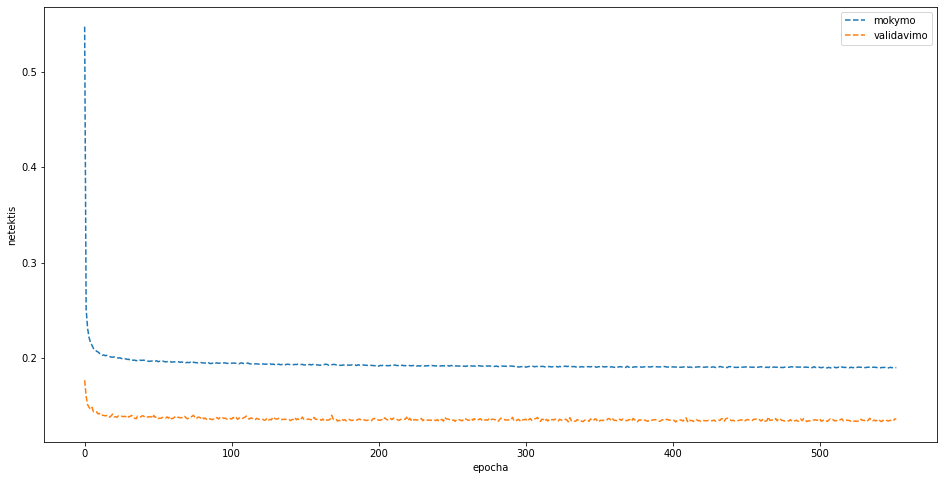

In [32]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.savefig(f'./plots/{DATA}_{MODEL_SUFFIX}_loss.png')
plt.show()

In [33]:
model.save(f'./models/{DATA}_{MODEL_SUFFIX}')

INFO:tensorflow:Assets written to: ./models/transcriptase_6_atmesta_random/assets
